# Plotting ROC/DET Curves and Calculate AUC

## Import and Data Loading

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import auc

from memoizer import memoize, load_cache

from tqdm.notebook import tqdm

In [2]:
PATH_ROOT = Path(Path.cwd().parent.parent.parent)
PATH_CACHE = Path(PATH_ROOT, "result", "cache")
PATH_FIG_ROC = Path(PATH_ROOT, "result", "figures", "ROC")
PATH_FIG_DET = Path(PATH_ROOT, "result", "figures", "DET")
SELF_NAME = "evaluate_roc.ipynb"

In [3]:
cache_t5_clean = Path(PATH_CACHE, "eval_t5_opengpt_final.pt")
cache_t5_dirty = Path(PATH_CACHE, "eval_t5_opengpt_original.pt")
cache_t5_gpt2  = Path(PATH_CACHE, "eval_t5_gpt2_output.pt")

cache_roberta_clean = Path(PATH_CACHE, "eval_roberta_opengpt_final.pt")
cache_roberta_dirty = Path(PATH_CACHE, "eval_roberta_opengpt_original.pt")
cache_roberta_gpt2  = Path(PATH_CACHE, "eval_roberta_gpt2_output.pt")

cache_gpt2_clean = Path(PATH_CACHE, "eval_gpt2_opengpt_final.pt")
cache_gpt2_dirty = Path(PATH_CACHE, "eval_gpt2_opengpt_original.pt")
cache_gpt2_gpt2  = Path(PATH_CACHE, "eval_gpt2_gpt2_output.pt")

cache_zero_clean = Path(PATH_CACHE, "eval_zerogpt_opengpt_final.pt")
cache_zero_dirty = Path(PATH_CACHE, "eval_zerogpt_opengpt_original.pt")
cache_zero_gpt2  = Path(PATH_CACHE, "eval_zerogpt_gpt2_output.pt")

cache_openai_clean = Path(PATH_CACHE, "eval_openai_opengpt_final.pt")
cache_openai_dirty = Path(PATH_CACHE, "eval_openai_opengpt_original.pt")
cache_openai_gpt2  = Path(PATH_CACHE, "eval_openai_gpt2_output.pt")

requirements = [
    cache_openai_clean, cache_openai_dirty, cache_openai_gpt2,
    cache_zero_clean, cache_zero_dirty, cache_zero_gpt2,
    cache_gpt2_clean, cache_gpt2_dirty, cache_gpt2_gpt2,
    cache_roberta_clean, cache_roberta_dirty, cache_roberta_gpt2,
    cache_t5_clean, cache_t5_dirty, cache_t5_gpt2 
]

if not all(map(Path.exists, requirements)):
    print("Not all required cache exists. Run evaluate_baseline.ipynb, evaluate_experiment.ipynb and [python -m data --baseline] before execute this notebook!")
    assert False

In [4]:
def get_statistics(prediction, threshold):
    # Positive -> Generated, Negative -> Human
    # prediction[key] = (P[Generate], P[Human])
    TP, TN, FP, FN = 0, 0, 0, 0
    for key in prediction:
        label = key.endswith("gpt")
        # y_hat == positive
        y_hat = prediction[key][0] >= threshold

        if   label == True and y_hat == True : TP += 1
        elif label == True and y_hat == False: FN += 1
        elif label == False and y_hat == True: FP += 1
        else: TN += 1
    
    return TP, TN, FP, FN

def get_curves(prediction, steps=100):
    result = {
        "TPRs": [], "TNRs": [], "FPRs": [], "FNRs": [],
        "TPs" : [], "TNs" : [], "FPs" : [], "FNs" : []
    }
    for step in range(0, steps + 1):
        thresh = step * (1 / (steps))
        tp, tn, fp, fn = get_statistics(prediction, thresh)
        tpr, tnr = tp / (tp + fn), tn / (tn + fp)
        fpr, fnr = fp / (fp + tn), fn / (fn + tp)
        result["TPs"].append(tp); result["TPRs"].append(tpr)
        result["TNs"].append(tn); result["TNRs"].append(tnr)
        result["FPs"].append(fp); result["FPRs"].append(fpr)
        result["FNs"].append(fn); result["FNRs"].append(fnr)
    return result

@memoize(Path(PATH_CACHE, "eval_roc_det_curves.pt"), SELF_NAME)
def calculate(**kwargs):
    return { key : get_curves(kwargs[key]) for key in tqdm(list(kwargs.keys())) }


## Calculate All Curves

In [5]:
curves = calculate(
    t5_clean      = load_cache(cache_t5_clean),
    t5_dirty      = load_cache(cache_t5_dirty),
    t5_gpt2       = load_cache(cache_t5_gpt2 ),
    roberta_clean = load_cache(cache_roberta_clean),
    roberta_dirty = load_cache(cache_roberta_dirty),
    roberta_gpt2  = load_cache(cache_roberta_gpt2 ),
    gpt2_clean    = load_cache(cache_gpt2_clean),
    gpt2_dirty    = load_cache(cache_gpt2_dirty),
    gpt2_gpt2     = load_cache(cache_gpt2_gpt2 ),
    zero_clean    = load_cache(cache_zero_clean),
    zero_dirty    = load_cache(cache_zero_dirty),
    zero_gpt2     = load_cache(cache_zero_gpt2),
    openai_clean  = load_cache(cache_openai_clean),
    openai_dirty  = load_cache(cache_openai_dirty),
    openai_gpt2   = load_cache(cache_openai_gpt2 ),
)

Loading cache from evaluate_experiment.ipynb
Loading cache from evaluate_experiment.ipynb
Loading cache from evaluate_experiment.ipynb
Loading cache from evaluate_experiment.ipynb
Loading cache from evaluate_experiment.ipynb
Loading cache from evaluate_experiment.ipynb
Loading cache from evaluate_gpt2_detector.ipynb
Loading cache from evaluate_gpt2_detector.ipynb
Loading cache from evaluate_gpt2_detector.ipynb
Loading cache from ./data/utility_fns.py
Loading cache from ./data/utility_fns.py
Loading cache from ./data/utility_fns.py
Loading cache from ./data/utility_fns.py
Loading cache from ./data/utility_fns.py
Loading cache from ./data/utility_fns.py


  0%|          | 0/15 [00:00<?, ?it/s]

## AUC Values

In [23]:
def print_auc_row(row, cols, curves):
    auc_value = [round(auc(curves[f"{row}_{col}"]["FPRs"], curves[f"{row}_{col}"]["TPRs"]), 3)
                 for col in cols]
    print(row + "\t & " + " & \t".join(map(str, auc_value)) + "\\\\")

cols = ["clean", "dirty", "gpt2"]
print("AUC Values")
print_auc_row("t5", cols, curves)
print_auc_row("roberta", cols, curves)
print_auc_row("zero", cols, curves)
print_auc_row("openai", cols, curves)
print_auc_row("gpt2", cols, curves)

AUC Values
t5	 & 0.993 & 	0.992 & 	0.463\\
roberta	 & 0.986 & 	0.976 & 	0.423\\
zero	 & 0.526 & 	0.555 & 	0.413\\
openai	 & 0.765 & 	0.752 & 	0.77\\
gpt2	 & 0.61 & 	0.6 & 	0.976\\


## DET Curves

In [7]:
def plotDETCurve(FNRs_arr, FPRs_arr, Label_arr, fileName, title):
    fig: plt.Figure = plt.figure(dpi=200)
    
    ax: plt.Axes = fig.add_subplot(1, 1, 1)
    
    for FNRs, FPRs, Label in zip(FNRs_arr, FPRs_arr, Label_arr):
        ax.plot(FPRs, FNRs, label=Label)
    
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("False Negative Rate")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ticks_to_use = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1]
    ax.set_xticks(ticks_to_use)
    ax.set_yticks(ticks_to_use)
    ax.grid(linestyle="--")
    ax.set_title(title)
    ax.legend()
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.show()
    fig.savefig(Path(PATH_FIG_DET, fileName))

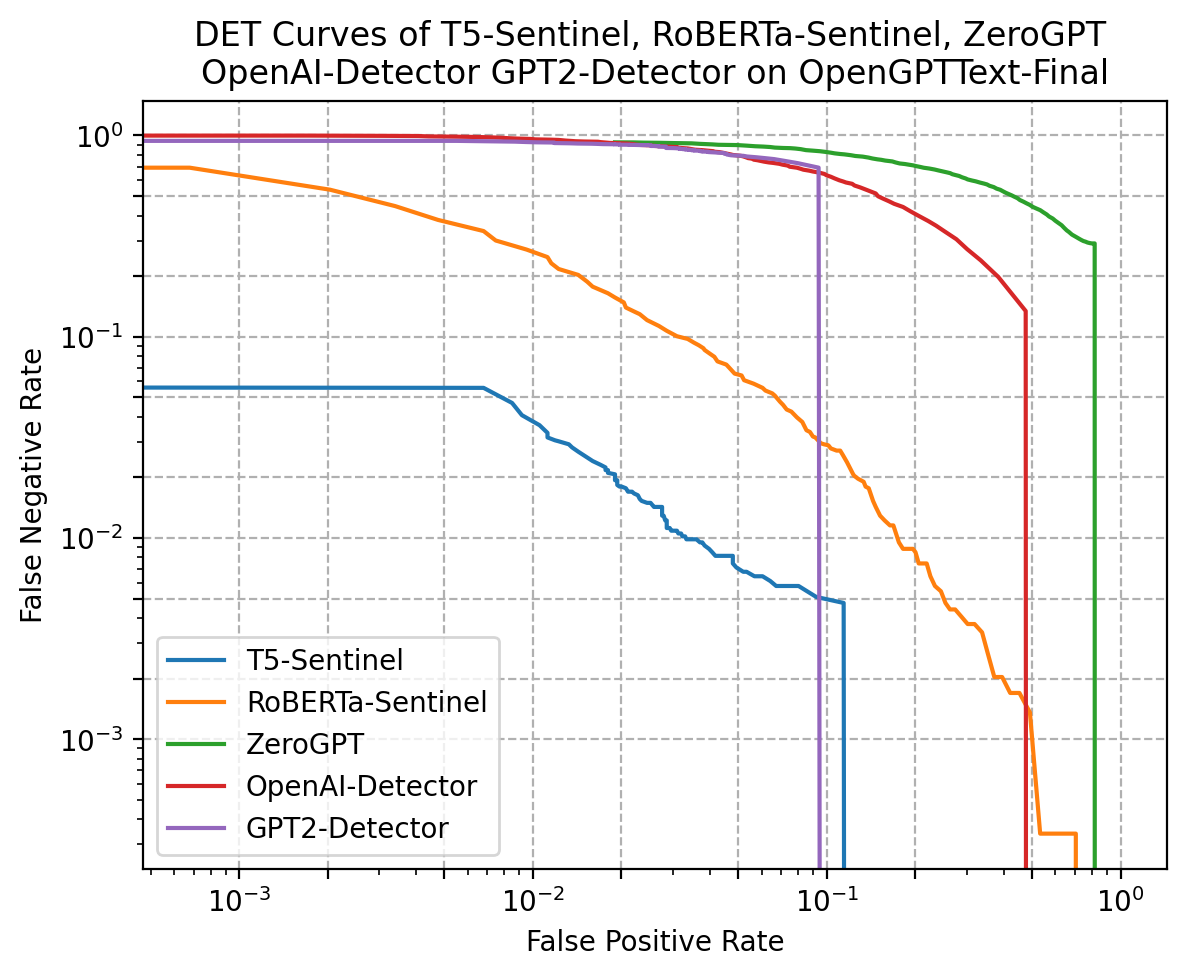

In [8]:
plotDETCurve(
    [curves["t5_clean"]["FNRs"], curves["roberta_clean"]["FNRs"], curves["zero_clean"]["FNRs"], curves["openai_clean"]["FNRs"], curves["gpt2_clean"]["FNRs"]],
    [curves["t5_clean"]["FPRs"], curves["roberta_clean"]["FPRs"], curves["zero_clean"]["FPRs"], curves["openai_clean"]["FPRs"], curves["gpt2_clean"]["FPRs"]],
    ["T5-Sentinel", "RoBERTa-Sentinel", "ZeroGPT", "OpenAI-Detector", "GPT2-Detector"],
    "DET_OpenGPTText-Final.pdf",
    "DET Curves of T5-Sentinel, RoBERTa-Sentinel, ZeroGPT \nOpenAI-Detector GPT2-Detector on OpenGPTText-Final"
)

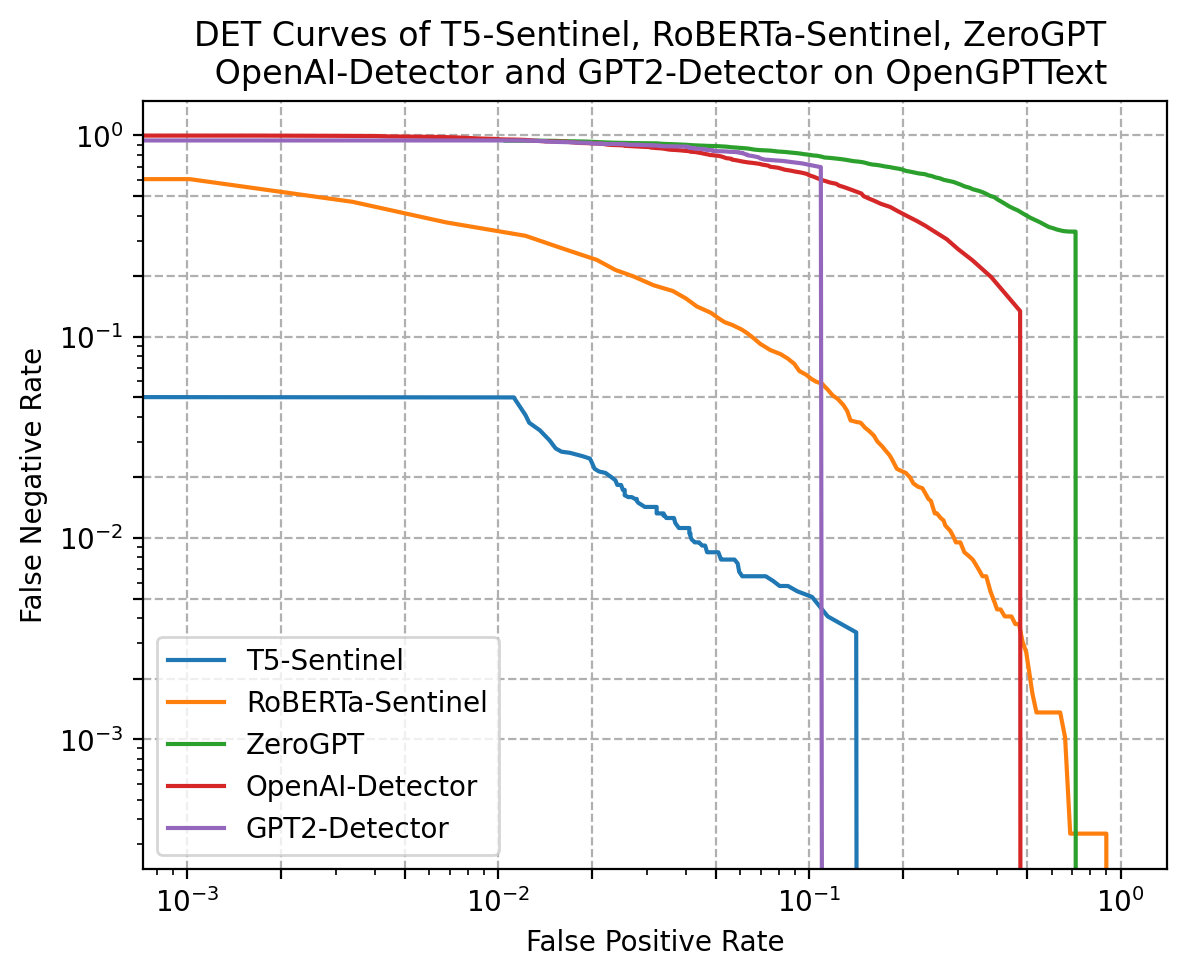

In [9]:
plotDETCurve(
    [curves["t5_dirty"]["FNRs"], curves["roberta_dirty"]["FNRs"], curves["zero_dirty"]["FNRs"], curves["openai_clean"]["FNRs"], curves["gpt2_dirty"]["FNRs"]],
    [curves["t5_dirty"]["FPRs"], curves["roberta_dirty"]["FPRs"], curves["zero_dirty"]["FPRs"], curves["openai_clean"]["FPRs"], curves["gpt2_dirty"]["FPRs"]],
    ["T5-Sentinel", "RoBERTa-Sentinel", "ZeroGPT", "OpenAI-Detector", "GPT2-Detector"],
    "DET_OpenGPTText-Original.pdf",
    "DET Curves of T5-Sentinel, RoBERTa-Sentinel, ZeroGPT \n OpenAI-Detector and GPT2-Detector on OpenGPTText"
)

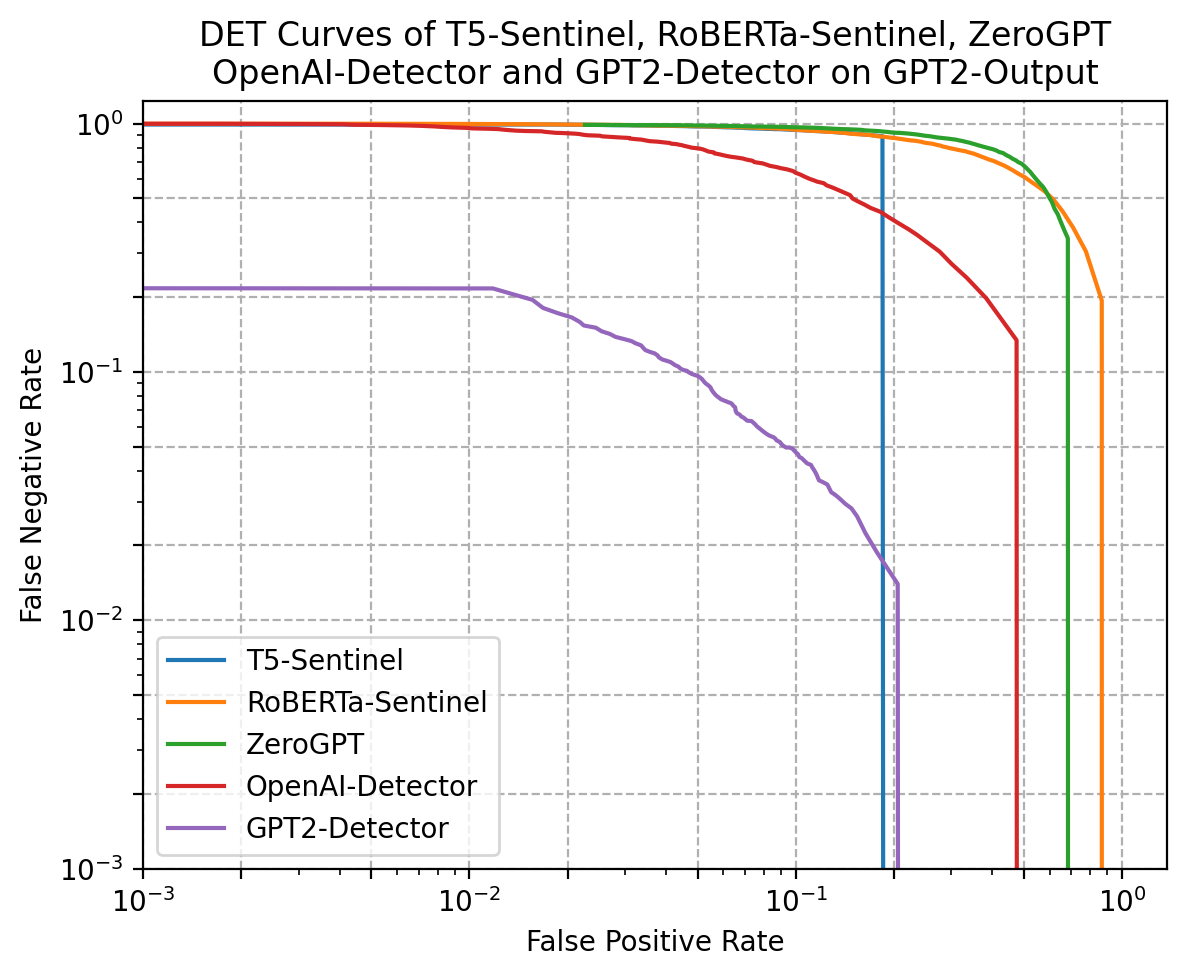

In [10]:
plotDETCurve(
    [curves["t5_gpt2"]["FNRs"], curves["roberta_gpt2"]["FNRs"], curves["zero_gpt2"]["FNRs"], curves["openai_clean"]["FNRs"], curves["gpt2_gpt2"]["FNRs"]],
    [curves["t5_gpt2"]["FPRs"], curves["roberta_gpt2"]["FPRs"], curves["zero_gpt2"]["FPRs"], curves["openai_clean"]["FPRs"], curves["gpt2_gpt2"]["FPRs"]],
    ["T5-Sentinel", "RoBERTa-Sentinel", "ZeroGPT", "OpenAI-Detector", "GPT2-Detector"],
    "DET_GPT2-Output.pdf",
    "DET Curves of T5-Sentinel, RoBERTa-Sentinel, ZeroGPT\nOpenAI-Detector and GPT2-Detector on GPT2-Output"
)

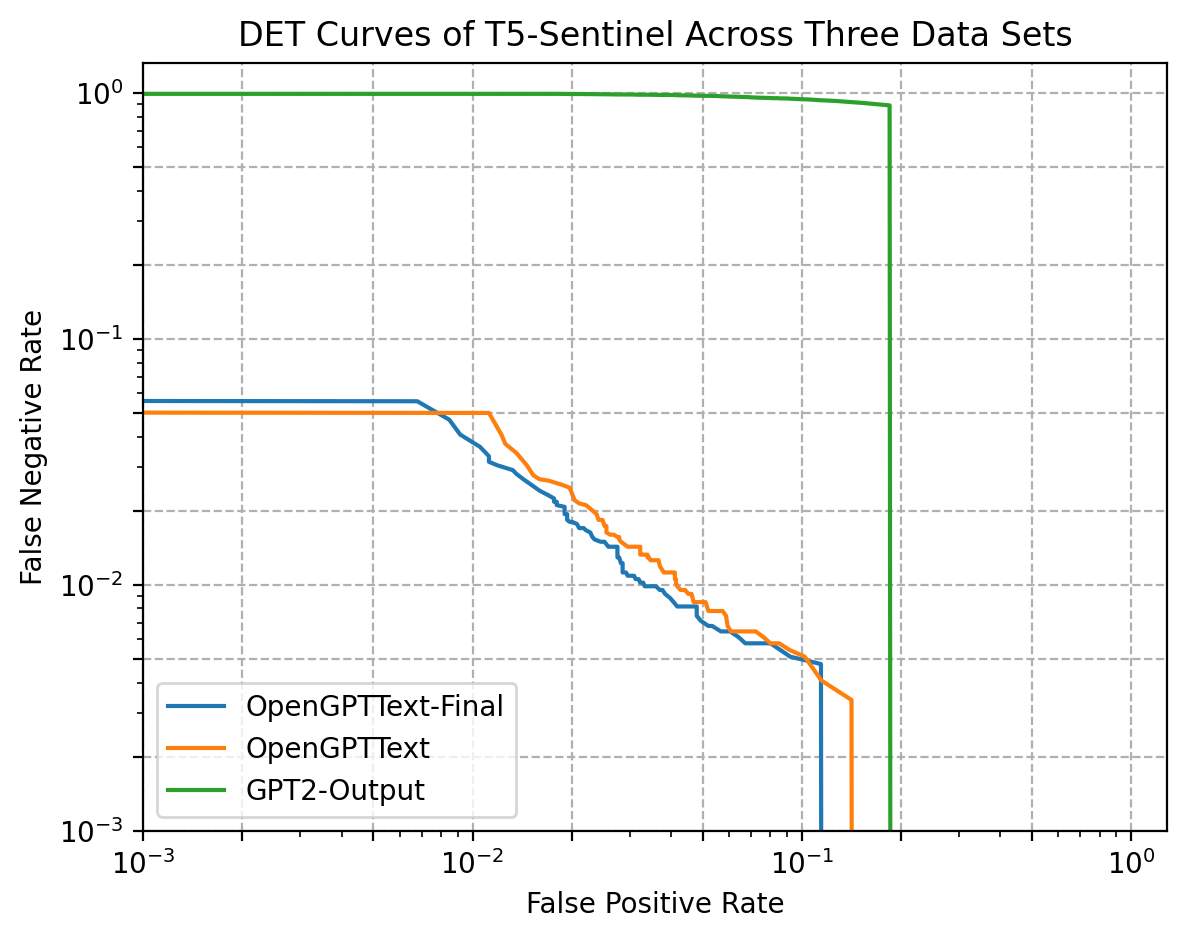

In [11]:
plotDETCurve(
    [curves["t5_clean"]["FNRs"], curves["t5_dirty"]["FNRs"], curves["t5_gpt2"]["FNRs"]],
    [curves["t5_clean"]["FPRs"], curves["t5_dirty"]["FPRs"], curves["t5_gpt2"]["FPRs"]],
    ["OpenGPTText-Final", "OpenGPTText", "GPT2-Output"],
    "DET_T5-Sentinel.pdf",
    "DET Curves of T5-Sentinel Across Three Data Sets"
)

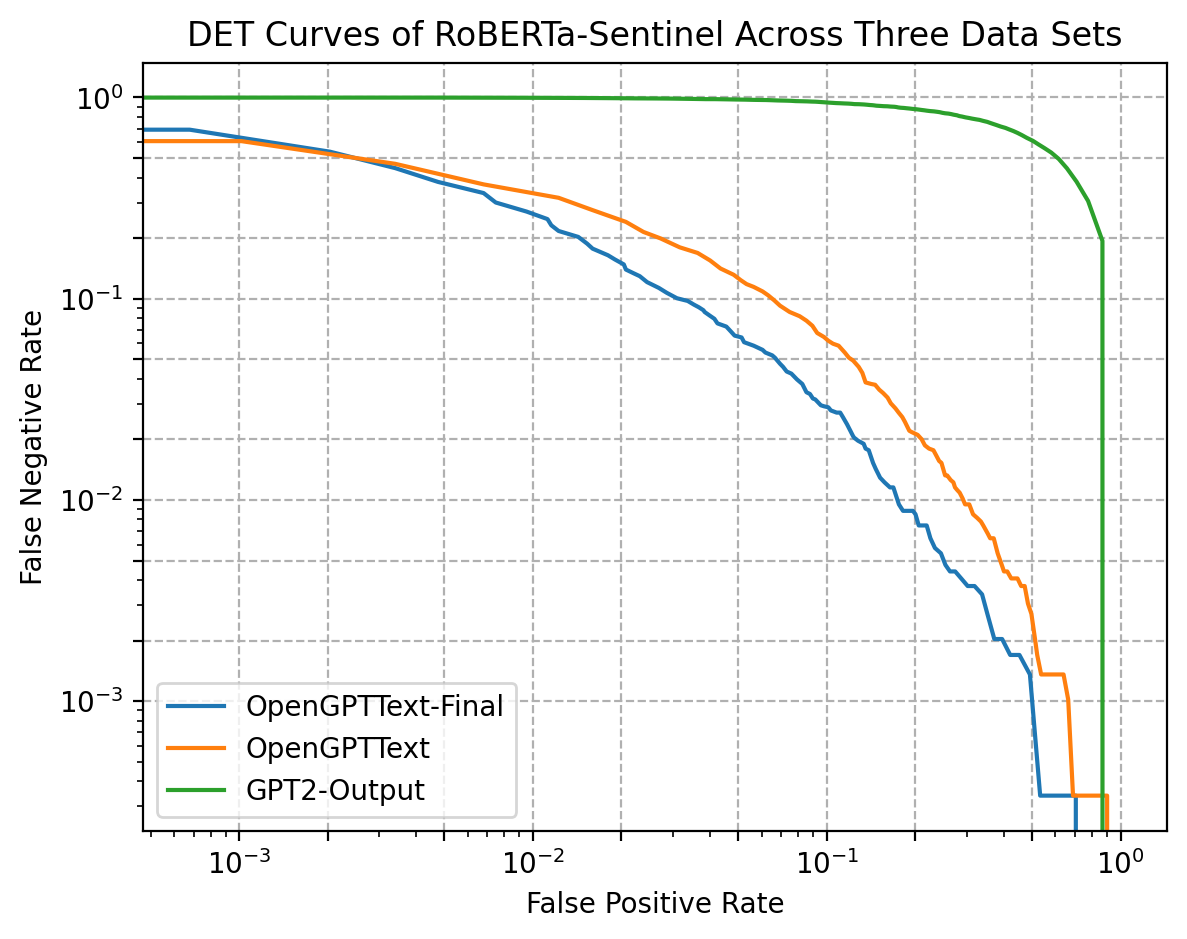

In [12]:
plotDETCurve(
    [curves["roberta_clean"]["FNRs"], curves["roberta_dirty"]["FNRs"], curves["roberta_gpt2"]["FNRs"]],
    [curves["roberta_clean"]["FPRs"], curves["roberta_dirty"]["FPRs"], curves["roberta_gpt2"]["FPRs"]],
    ["OpenGPTText-Final", "OpenGPTText", "GPT2-Output"],
    "DET_RoBERTa-Sentinel.pdf",
    "DET Curves of RoBERTa-Sentinel Across Three Data Sets"
)

## ROC Curves

In [13]:
def plotROCCurve(FPRs_arr, TPRs_arr, Label_arr, fileName, title):
    fig: plt.Figure = plt.figure(dpi=200)
    
    ax: plt.Axes = fig.add_subplot(1, 1, 1)
    
    for FPRs, TPRs, Label in zip(FPRs_arr, TPRs_arr, Label_arr):
        ax.plot(FPRs, TPRs, label=Label)
    
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.grid(linestyle="--")
    ax.set_title(title)
    ax.legend()
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.show()
    fig.savefig(Path(PATH_FIG_ROC, fileName))

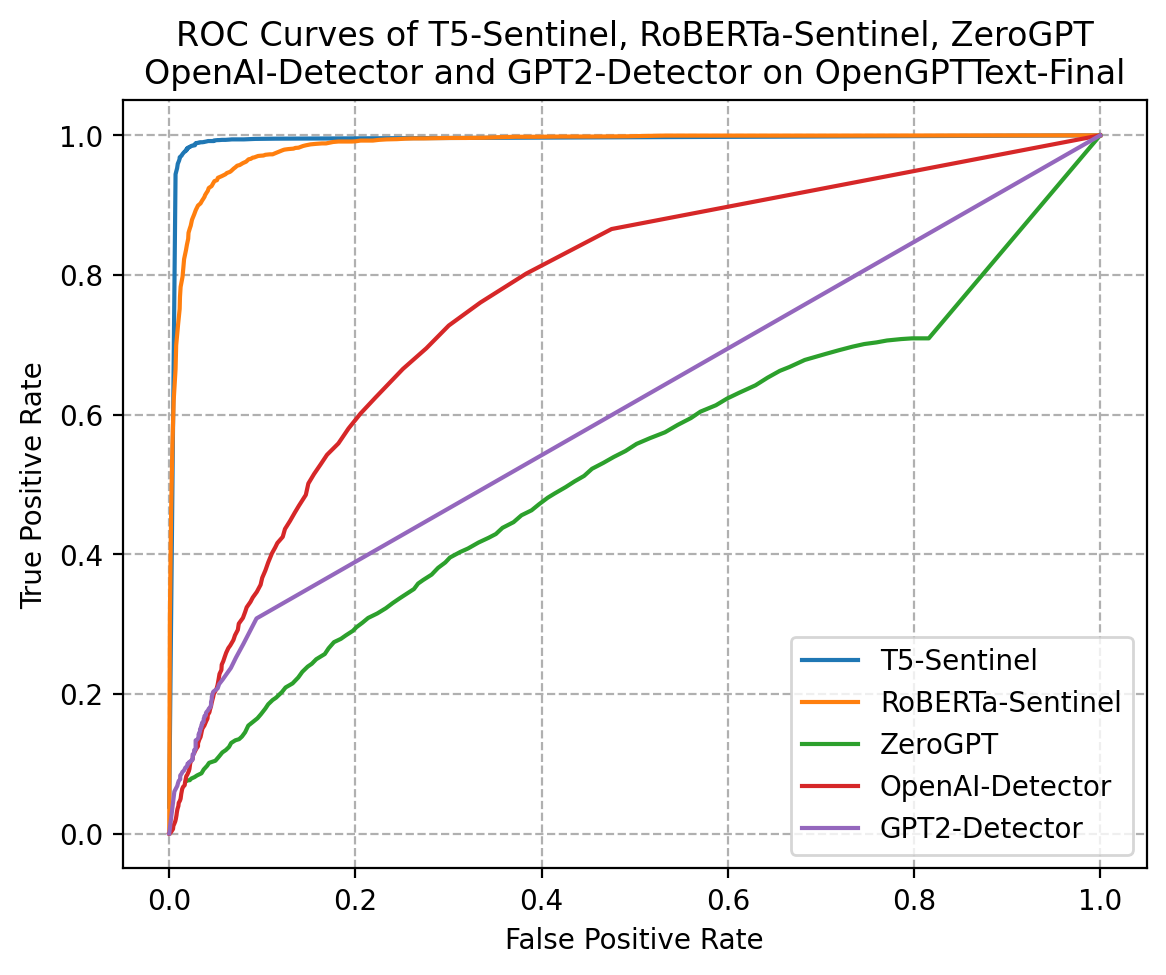

In [14]:
plotROCCurve(
    [curves["t5_clean"]["FPRs"], curves["roberta_clean"]["FPRs"], curves["zero_clean"]["FPRs"], curves["openai_clean"]["FPRs"], curves["gpt2_clean"]["FPRs"]],
    [curves["t5_clean"]["TPRs"], curves["roberta_clean"]["TPRs"], curves["zero_clean"]["TPRs"], curves["openai_clean"]["TPRs"], curves["gpt2_clean"]["TPRs"]],
    ["T5-Sentinel", "RoBERTa-Sentinel", "ZeroGPT", "OpenAI-Detector", "GPT2-Detector"],
    "ROC_OpenGPTText_Final.pdf",
    "ROC Curves of T5-Sentinel, RoBERTa-Sentinel, ZeroGPT\nOpenAI-Detector and GPT2-Detector on OpenGPTText-Final"
)

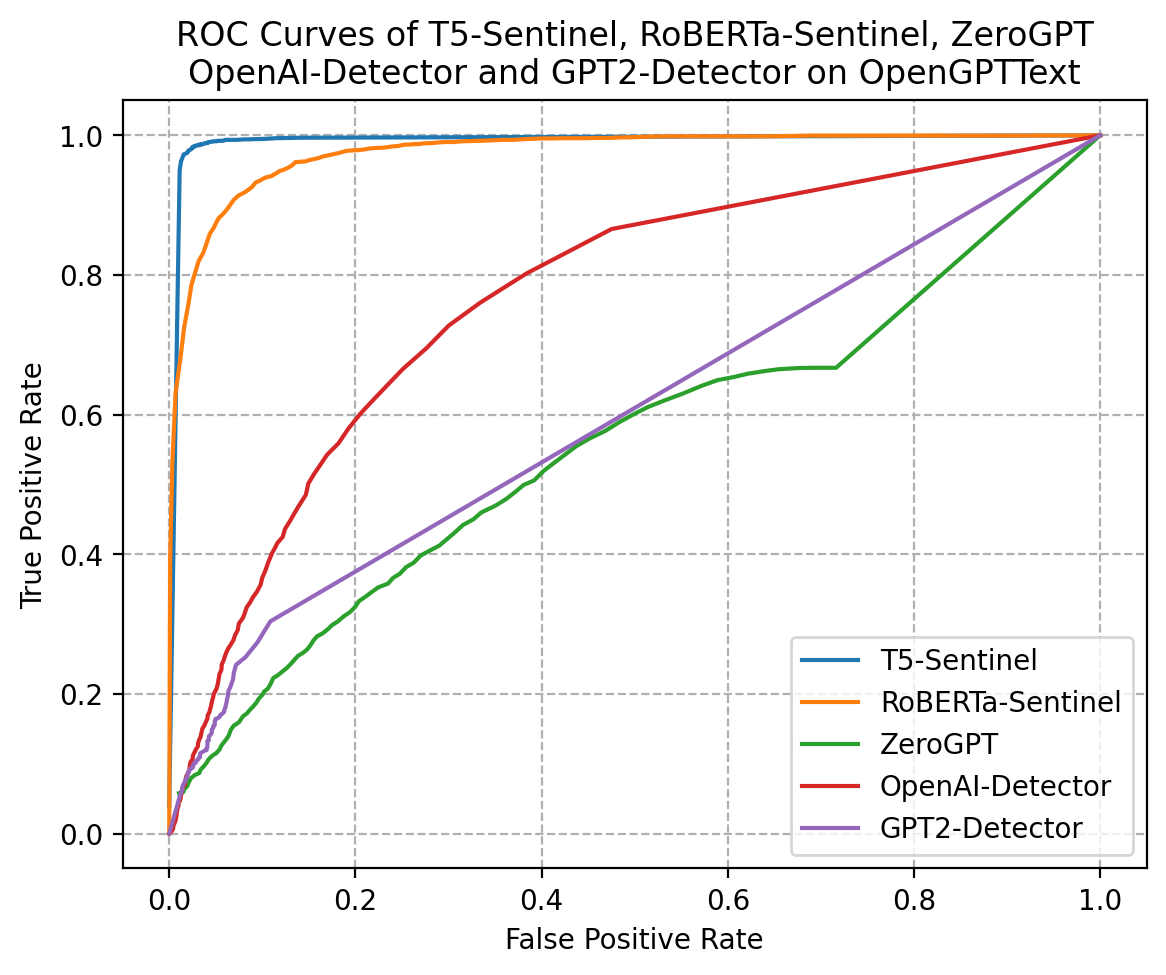

In [15]:
plotROCCurve(
    [curves["t5_dirty"]["FPRs"], curves["roberta_dirty"]["FPRs"], curves["zero_dirty"]["FPRs"], curves["openai_clean"]["FPRs"], curves["gpt2_dirty"]["FPRs"]],
    [curves["t5_dirty"]["TPRs"], curves["roberta_dirty"]["TPRs"], curves["zero_dirty"]["TPRs"], curves["openai_clean"]["TPRs"], curves["gpt2_dirty"]["TPRs"]],
    ["T5-Sentinel", "RoBERTa-Sentinel", "ZeroGPT", "OpenAI-Detector", "GPT2-Detector"],
    "ROC_OpenGPTText_Original.pdf",
    "ROC Curves of T5-Sentinel, RoBERTa-Sentinel, ZeroGPT\nOpenAI-Detector and GPT2-Detector on OpenGPTText"
)

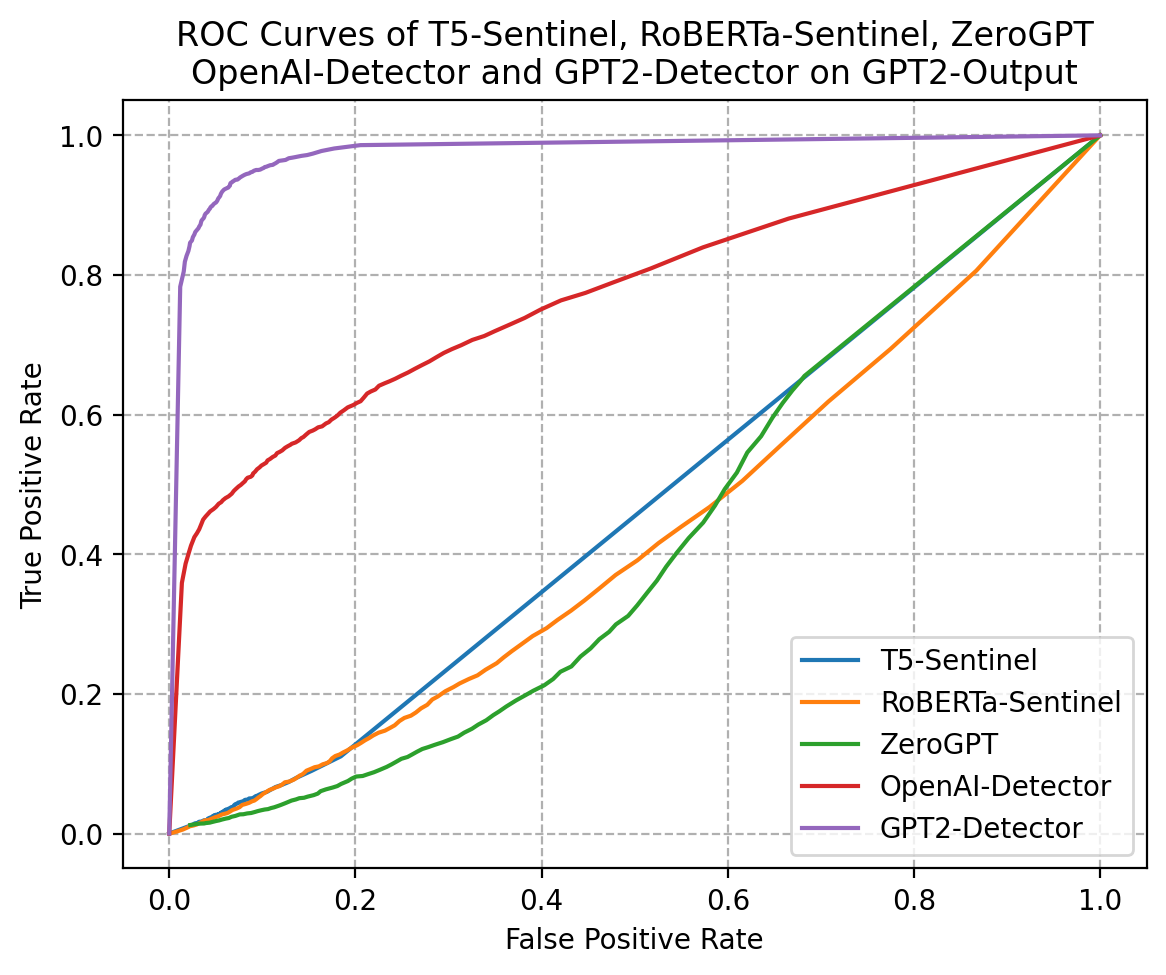

In [19]:
plotROCCurve(
    [curves["t5_gpt2"]["FPRs"], curves["roberta_gpt2"]["FPRs"], curves["zero_gpt2"]["FPRs"], curves["openai_gpt2"]["FPRs"], curves["gpt2_gpt2"]["FPRs"]],
    [curves["t5_gpt2"]["TPRs"], curves["roberta_gpt2"]["TPRs"], curves["zero_gpt2"]["TPRs"], curves["openai_gpt2"]["TPRs"], curves["gpt2_gpt2"]["TPRs"]],
    ["T5-Sentinel", "RoBERTa-Sentinel", "ZeroGPT", "OpenAI-Detector", "GPT2-Detector"],
    "ROC_GPT2_Output.pdf",
    "ROC Curves of T5-Sentinel, RoBERTa-Sentinel, ZeroGPT\nOpenAI-Detector and GPT2-Detector on GPT2-Output"
)

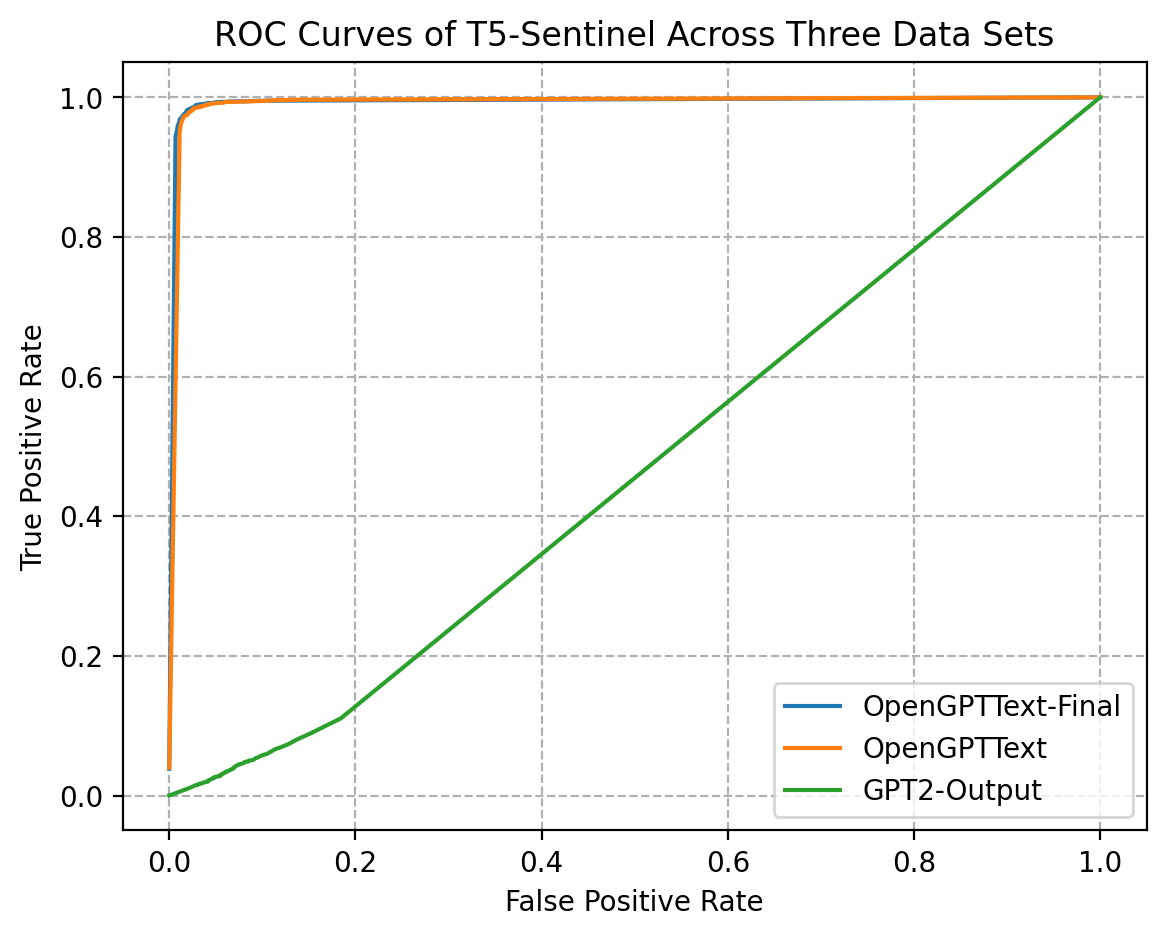

In [17]:
plotROCCurve(
    [curves["t5_clean"]["FPRs"], curves["t5_dirty"]["FPRs"], curves["t5_gpt2"]["FPRs"]],
    [curves["t5_clean"]["TPRs"], curves["t5_dirty"]["TPRs"], curves["t5_gpt2"]["TPRs"]],
    ["OpenGPTText-Final", "OpenGPTText", "GPT2-Output"],
    "ROC_T5-Sentinel.pdf",
    "ROC Curves of T5-Sentinel Across Three Data Sets"
)

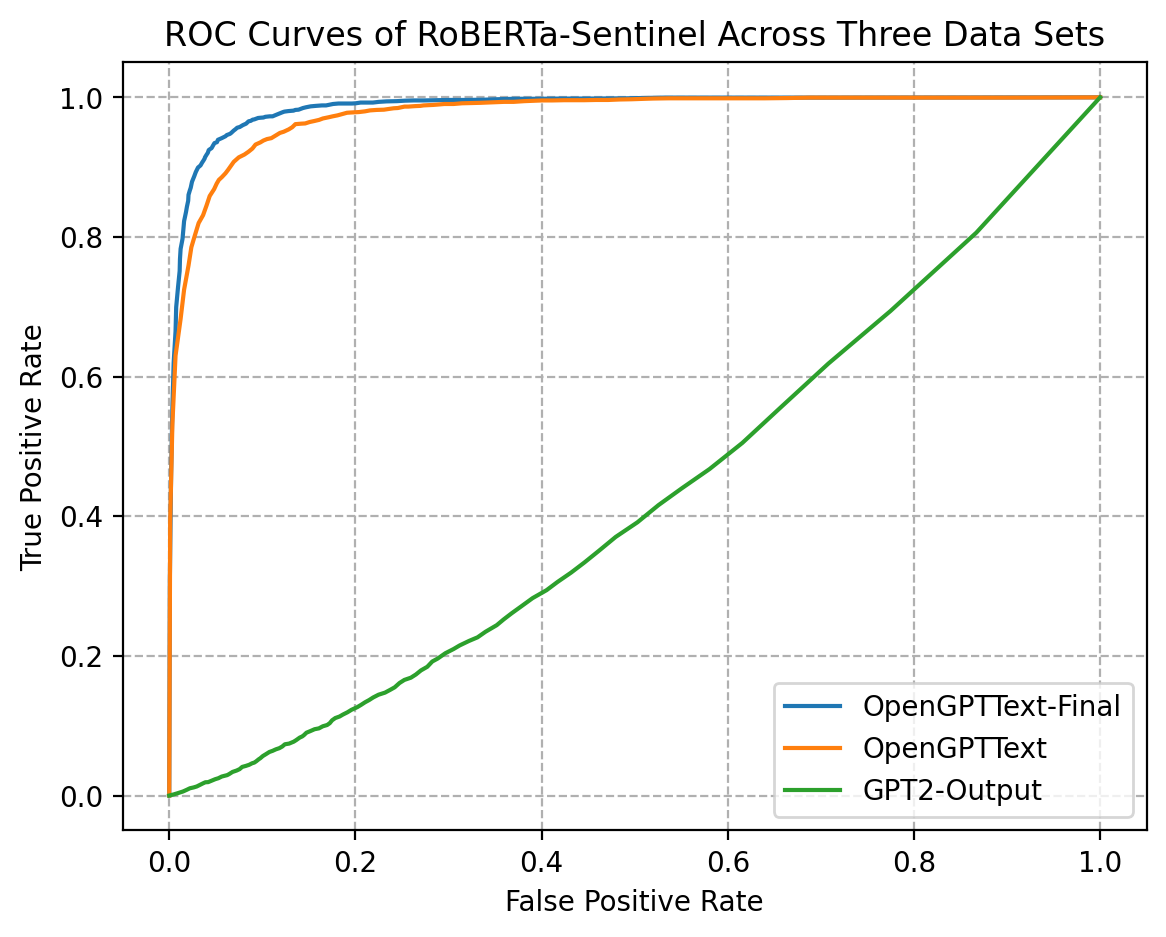

In [18]:
plotROCCurve(
    [curves["roberta_clean"]["FPRs"], curves["roberta_dirty"]["FPRs"], curves["roberta_gpt2"]["FPRs"]],
    [curves["roberta_clean"]["TPRs"], curves["roberta_dirty"]["TPRs"], curves["roberta_gpt2"]["TPRs"]],
    ["OpenGPTText-Final", "OpenGPTText", "GPT2-Output"],
    "ROC_RoBERTa-Sentinel.pdf",
    "ROC Curves of RoBERTa-Sentinel Across Three Data Sets"
)